In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [21]:
#  Preparing YOLO Dataset

# Create folders for images and labels (train/val)
# Write dataset.yaml file needed by YOLO for training (paths + class names)
#For each image:
    #   - Read image and get height/width
    #   - Convert bounding box (xmin, ymin, xmax, ymax) to YOLO format (x_center, y_center, width, height) normalized by image size


# Converts your bounding box annotations into the format YOLO requires, organizes images and labels into folders, and splits into train/val sets.
# YOLO requires bounding box annotations in a very specific format for training.

# Each annotation label file (one per image) contains one line per object, formatted as:
# <class_id> <x_center> <y_center> <width> <height>

# class_id: Integer representing the object class (e.g., 0 for license_plate).
# x_center: Horizontal center of the bounding box, normalized by the image width (value between 0 and 1).
# y_center: Vertical center of the bounding box, normalized by the image height (value between 0 and 1).
# width: Width of the bounding box, normalized by image width (0 to 1).
# height: Height of the bounding box, normalized by image height (0 to 1).


# Each image can have different height and width -  calcluated by :  h, w = img.shape[:2]

# example)
# img_id	ymin	xmin	ymax	xmax
# 1.jpg	276	94	326	169

# x_center = (94 + 169) / 2 / 400 = 0.329
# y_center = (276 + 326) / 2 / 500 = 0.602
# width = (169 - 94) / 400 = 0.188
# height = (326 - 276) / 500 = 0.1

# YOLO line:
# 0 0.329 0.602 0.188 0.1


# for each image a label.txt is created - for /images/train/1.jpg -> /labels/train/1.txt is created in which this YOLO ANNOTATIONS are stored


In [22]:
# dataset.yaml

# It's a configuration file that tells YOLO where your dataset is and what classes you want the model to detect.

# Your dataset.yaml tells YOLO:
#     Training images are in yolo_dataset/images/train
#     Validation images are in yolo_dataset/images/val
#     There is only one class: license_plate (class ID 0)

# This config is passed during training so YOLO learns to detect license plates specifically.


# When you call the YOLO training function with data='yolo_dataset/dataset.yaml', the model reads this file.

# YOLO automatically adjusts its final detection layers to output predictions for exactly one class instead of the original 80 classes.

# This is how the pretrained model is fine-tuned to your specific task.

In [23]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import tensorflow as tf
from tensorflow.keras import layers, models

# Prepare YOLO format dataset
def prepare_yolo_dataset(detection_df, img_folder=r'C:\Users\anilk\Downloads\numb_plate_rec\license_plates_detection_train', output_folder='yolo_dataset'):
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(os.path.join(output_folder, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_folder, 'labels'), exist_ok=True)
    
    # Create dataset.yaml
    with open(os.path.join(output_folder, 'dataset.yaml'), 'w') as f:
        f.write(f"""path: {os.path.abspath(output_folder)}
train: images/train
val: images/val
test: images/test

names:
  0: license_plate
""")

    # Split data
    train_df, val_df = train_test_split(detection_df, test_size=0.2, random_state=42)
    
    # Process each split
    for df, split in [(train_df, 'train'), (val_df, 'val')]:
        split_img_dir = os.path.join(output_folder, 'images', split)
        split_label_dir = os.path.join(output_folder, 'labels', split)
        os.makedirs(split_img_dir, exist_ok=True)
        os.makedirs(split_label_dir, exist_ok=True)
        
        for _, row in df.iterrows():
            img_path = os.path.join(img_folder, row['img_id'])
            img = cv2.imread(img_path)
            h, w = img.shape[:2]
            
            # Calculate YOLO format annotations
            x_center = ((row['xmin'] + row['xmax']) / 2) / w
            y_center = ((row['ymin'] + row['ymax']) / 2) / h
            width = (row['xmax'] - row['xmin']) / w
            height = (row['ymax'] - row['ymin']) / h
            
            # Save image
            new_img_path = os.path.join(split_img_dir, row['img_id'])
            cv2.imwrite(new_img_path, img)
            
            # Save label
            label_path = os.path.join(split_label_dir, os.path.splitext(row['img_id'])[0] + '.txt')
            with open(label_path, 'w') as f:
                f.write(f"0 {x_center} {y_center} {width} {height}")

# Load detection annotations  
detection_df = pd.read_csv(r'C:\Users\anilk\Downloads\numb_plate_rec\Licplatesdetection_train.csv')
prepare_yolo_dataset(detection_df)

In [ ]:
# What kind of images is YOLO pretrained on?

# Usually, models like yolov8n.pt are pretrained on large, diverse datasets such as COCO (Common Objects in Context).
# COCO has over 300,000 images with 80 common object classes (people, cars, animals, furniture, etc.).
# These images cover a wide variety of scenes, lighting conditions, angles, and object sizes.



# What basic features does the pretrained model know?

# The model’s early layers have learned to detect low-level features like:
# Edges, Corners, Textures, Simple shapes (lines, curves)

# Middle layers detect more complex patterns, like:
# Parts of objects (wheels, faces, windows), Combinations of shapes

# Deeper layers recognize high-level concepts that correspond to whole objects or important regions.



# WHY DID WE USE YOLO HERE..?

# Because these features are generic and transferable, the pretrained model can quickly adapt to your license plate detection task.
# Instead of learning everything from scratch, it fine-tunes the weights to recognize license plates specifically, 
# saving training time and improving accuracy.

In [3]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import torch

# Verify device availability
# Checks if your machine has GPU support via CUDA (important for faster training).
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA devices: {torch.cuda.device_count()}")

def train_detection_model():
    # Load pretrained model
    model = YOLO('yolov8n.pt')
    
    # Training parameters optimized for CPU
    results = model.train(
        data=os.path.abspath('yolo_dataset/dataset.yaml'),
        epochs=25,           # Reduced epochs for quicker training on CPU
        imgsz=416,          # Smaller image size
        batch=4,            # Smaller batch size
        device='cpu',       # Force CPU usage
        workers=0,          # Disable multiprocessing if memory issues
        patience=10,        # Early stopping if no improvement
        lr0=0.01,           # Initial learning rate
        lrf=0.01,           # Final learning rate
        optimizer='Adam',   # Might work better than SGD on CPU
        seed=42
    )
    
    return model

# Run training
try:
    detection_model = train_detection_model()
except Exception as e:
    print(f"Error during training: {e}")
    print("Trying with even more conservative settings...")
    
    # Fallback with ultra-conservative settings
    model = YOLO('yolov8n.pt')
    results = model.train(
        data=os.path.abspath('yolo_dataset/dataset.yaml'),
        epochs=30,
        imgsz=320,
        batch=2,
        device='cpu',
        workers=0
    )
    detection_model = model

CUDA available: False
CUDA devices: 0
New https://pypi.org/project/ultralytics/8.3.134 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.2  Python-3.11.4 torch-2.2.2+cpu CPU (Intel Core(TM) i5-1035G1 1.00GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:\Users\anilk\yolo_dataset\dataset.yaml, epochs=25, time=None, patience=10, batch=4, imgsz=416, save=True, save_period=-1, cache=False, device=cpu, workers=0, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=

train: Scanning C:\Users\anilk\yolo_dataset\labels\train.cache... 720 images, 0 backgrounds, 0 corrupt: 100%|██████████
val: Scanning C:\Users\anilk\yolo_dataset\labels\val.cache... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18


Plotting labels to runs\detect\train4\labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs\detect\train4
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         0G      1.719      1.504      1.359          8        416: 100%|██████████| 180/180 [07:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:43

                   all        180        180      0.486      0.611        0.5      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25         0G      1.603      1.161      1.338         10        416: 100%|██████████| 180/180 [07:19<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:24

                   all        180        180      0.847      0.767      0.889      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25         0G      1.612      1.093      1.311          6        416: 100%|██████████| 180/180 [04:26<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:23

                   all        180        180      0.921      0.806      0.896      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25         0G      1.561      1.044      1.309          7        416: 100%|██████████| 180/180 [04:23<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:23

                   all        180        180      0.787      0.779      0.828      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25         0G      1.492     0.9532      1.263          4        416: 100%|██████████| 180/180 [04:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:23

                   all        180        180      0.944      0.932      0.976      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25         0G      1.493     0.9276      1.251          7        416: 100%|██████████| 180/180 [04:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:23

                   all        180        180      0.889      0.861      0.943      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25         0G       1.48     0.9635      1.243          8        416: 100%|██████████| 180/180 [04:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:23

                   all        180        180      0.851      0.878      0.949      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25         0G      1.379     0.9094      1.182          6        416: 100%|██████████| 180/180 [04:19<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:22

                   all        180        180      0.924      0.967      0.979      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25         0G      1.349      0.854      1.163          4        416: 100%|██████████| 180/180 [04:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:23

                   all        180        180      0.912      0.919      0.968      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25         0G      1.286     0.8045      1.126          6        416: 100%|██████████| 180/180 [04:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:22

                   all        180        180      0.979      0.917      0.983      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25         0G      1.293     0.7999      1.153          6        416: 100%|██████████| 180/180 [04:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:22

                   all        180        180      0.977      0.922      0.984      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25         0G      1.266     0.7967      1.115         11        416: 100%|██████████| 180/180 [04:24<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:23

                   all        180        180      0.965      0.929       0.98      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25         0G      1.198     0.7645      1.094          7        416: 100%|██████████| 180/180 [04:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:22

                   all        180        180       0.97      0.922      0.985      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25         0G      1.198     0.7162      1.091         11        416: 100%|██████████| 180/180 [04:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:22

                   all        180        180      0.976      0.917      0.983      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25         0G      1.252     0.7409        1.1          6        416: 100%|██████████| 180/180 [04:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:22

                   all        180        180      0.918      0.978      0.987      0.691


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25         0G      1.124     0.6355      1.098          4        416: 100%|██████████| 180/180 [04:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:22

                   all        180        180      0.932      0.986      0.984      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25         0G      1.134     0.6538      1.072          4        416: 100%|██████████| 180/180 [04:12<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:22

                   all        180        180      0.984      0.911      0.989      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25         0G      1.041     0.6204      1.056          4        416: 100%|██████████| 180/180 [04:09<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:22

                   all        180        180      0.956      0.977      0.991      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25         0G      1.053     0.6127      1.038          4        416: 100%|██████████| 180/180 [04:08<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:22

                   all        180        180      0.943      0.972      0.991      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25         0G      1.066     0.5876      1.053          4        416: 100%|██████████| 180/180 [04:15<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:22

                   all        180        180      0.986      0.989      0.994      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25         0G      1.031     0.5604      1.047          4        416: 100%|██████████| 180/180 [04:08<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:22

                   all        180        180      0.971      0.994      0.994      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25         0G      1.016     0.5413      1.034          3        416: 100%|██████████| 180/180 [04:25<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:24

                   all        180        180       0.97      0.994      0.992      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25         0G     0.9668      0.533      1.012          4        416: 100%|██████████| 180/180 [04:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:21

                   all        180        180      0.963      0.994      0.988      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25         0G     0.9705      0.517     0.9992          4        416: 100%|██████████| 180/180 [04:10<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:18

                   all        180        180      0.973      0.994      0.988      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25         0G     0.9416     0.4972      1.005          4        416: 100%|██████████| 180/180 [04:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:19

                   all        180        180      0.967      0.989      0.993      0.769



25 epochs completed in 2.078 hours.
Optimizer stripped from runs\detect\train4\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train4\weights\best.pt, 6.2MB

Validating runs\detect\train4\weights\best.pt...
Ultralytics YOLOv8.2.2  Python-3.11.4 torch-2.2.2+cpu CPU (Intel Core(TM) i5-1035G1 1.00GHz)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:18


                   all        180        180      0.967       0.99      0.993      0.769
Speed: 1.1ms preprocess, 86.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\train4


In [ ]:
# ----------- METRICS USED -----------


# GPU_mem: Memory used on GPU (0G means CPU training)
# box_loss: Loss related to bounding box regression (how well the model predicts the box location and size)
# cls_loss: Classification loss (how well the model predicts the correct class, here just one class)
# dfl_loss: Distribution Focal Loss, helps with more precise bounding box regression
# Instances: Number of labeled objects processed in that batch (e.g., 4)
# Size: Input image size (e.g., 416 x 416 pixels)


# mAP50 means mean Average Precision at 50% IoU.
# mAP50-95 means the mean Average Precision averaged over IoU thresholds from 50% to 95% (in steps of 5%).

# IoU threshold (Intersection over Union threshold) is a number that decides when a predicted bounding box is considered a correct detection.
# It measures how much the predicted box overlaps with the actual (ground truth) box.

# Formula:
# LoU= Area of Overlap / Area of Union
# IoU ranges from 0 (no overlap) to 1 (perfect overlap).

# 0.5 (50%) IoU threshold means the predicted box needs at least 50% overlap with the real box to count as correct.
# Higher thresholds (like 0.75 or 0.95) require more precise overlap.

# mAP50, it means the model is evaluated with an IoU threshold of 0.5 (50%).
# When you see mAP50-95, it means the model is tested over multiple thresholds from 0.5 to 0.95, making the evaluation stricter.


# Precision(P) and Recall(R) see, (class 0 is predicted or not)
#     - Of all the objects your model predicted, how many were actually correct? = P
#     - Of all the actual objects, how many did your model find? = R


# THAT IS, 
# During evaluation (precision, recall, mAP), it checks:
#     Did it correctly detect the object as class 0 (license plate)?
#     Was the location (bounding box) close enough (based on IoU threshold)?

In [19]:
from ultralytics import YOLO

# Load the trained model
model = YOLO('runs/detect/train4/weights/best.pt')

# Run validation
metrics = model.val()

# Print metrics
print("mAP50: ", metrics.box.map50)
print("mAP50-95: ", metrics.box.map)
print("Mean Precision: ", metrics.box.mp)  
print("Mean Recall: ", metrics.box.mr) 


Ultralytics YOLOv8.2.2  Python-3.11.4 torch-2.2.2+cpu CPU (Intel Core(TM) i5-1035G1 1.00GHz)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\anilk\yolo_dataset\labels\val.cache... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:14


                   all        180        180      0.967      0.991      0.993      0.768
Speed: 1.0ms preprocess, 67.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\val3
mAP50:  0.9931431530407826
mAP50-95:  0.7676043292566268
Mean Precision:  0.9674715363008394
Mean Recall:  0.9914176811857149


In [1]:
from ultralytics import YOLO

# Load the trained model
model = YOLO('runs/detect/train4/weights/best.pt')

In [2]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load the trained model
model = YOLO('runs/detect/train4/weights/best.pt')

def detect_license_plate(image_path):
    # Predict
    results = model(image_path)[0]
    
    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    
    # Draw bounding boxes
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        cls_id = int(box.cls[0])

        # Draw green box and label
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image_rgb, f'{model.names[cls_id]} {conf:.2f}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    # Display using matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()



image 1/1 C:\Users\anilk\Downloads\numb_plate_rec\test\922.jpg: 416x416 1 license_plate, 108.9ms
Speed: 3.0ms preprocess, 108.9ms inference, 2828.7ms postprocess per image at shape (1, 3, 416, 416)


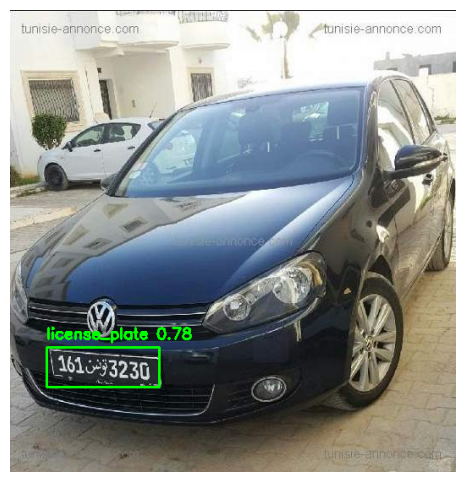

In [3]:
detect_license_plate(r'C:\Users\anilk\Downloads\numb_plate_rec\test\922.jpg')


image 1/1 C:\Users\anilk\Downloads\download (1).jpeg: 256x416 1 license_plate, 108.5ms
Speed: 22.3ms preprocess, 108.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 416)


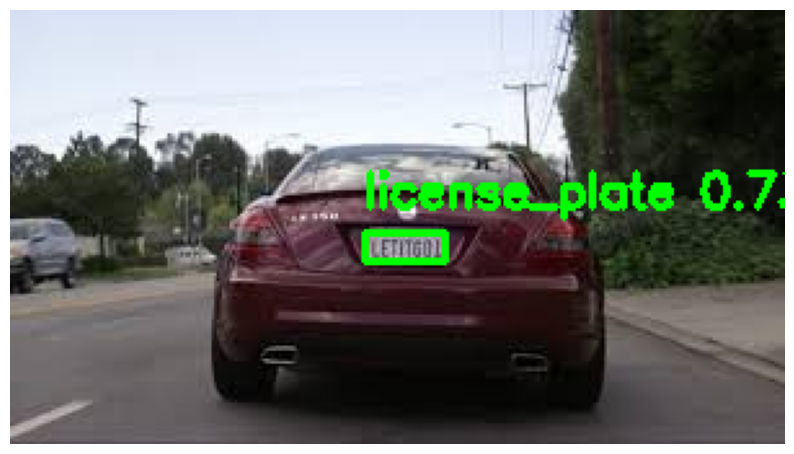

In [4]:
# image from internet

detect_license_plate(r'C:\Users\anilk\Downloads\download (1).jpeg')